# Introduction

## Background
The dataset consists of many different types of macromolecules of biological signifiance. The majority of the data records are of proteins. With DNA being the precursor to RNA, which when translated, proteins are the biomolecules that are directly interacting in biological pathways and cycles. Proteins are usually centered around one or a few job which is defined by their family type. For example, we can have a protein that is from a Hydrolase group, which focuses on catalyzing hydrolysis (breaking bonds by adding water) in order to help promote destruction of chains of proteins, or other molecules. Another example would be a protein that is a transport protein, which allows other molecules such as sucrose, fructose, or even water come in and outside of the cell. 

## Goals
With these proteins having different family types, a question arises if it's possible to determine a protein's family type based on sequence. There are notable search engines such as BLAST which has this capability, but it'd be interesting to see if a machine learning approach can do a good job in classifying a protein's family based on the protein sequence.

### 1). Import Dataset
* Data source/kernel (from PDB): https://www.kaggle.com/shahir/protein-data-set 

In [1]:
# 1). ----- Import Libraries and Datasets ------

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report


# Import Datasets
df_seq = pd.read_csv('../input/pdb_data_seq.csv')
df_char = pd.read_csv('../input/pdb_data_no_dups.csv')

print('Datasets have been loaded...')

Datasets have been loaded...


### 2) Filter and Process Data
With the data loaded into two seperate pandas dataframes, a filter, project, and a join must be performed to get the data together. A good library here to check out is the dfply, which is similar to the dplyr library from R. Nevertheless, pandas offers a way to perform these SQL-like commands. Begin by first filtering the datasets where the classification is equal to 'Protein', followed by removing all other variables  other than structureId and sequence for the data_seq_csv, and structureId and classification in the no_dups dataset.

In [2]:
# 2). ----- Filter and Process Dataset ------

# Filter for only proteins
protein_char = df_char[df_char.macromoleculeType == 'Protein']
protein_seq = df_seq[df_seq.macromoleculeType == 'Protein']

In [3]:
protein_char.head()

,structureId,classification,experimentalTechnique,macromoleculeType,residueCount,resolution,structureMolecularWeight,crystallizationMethod,crystallizationTempK,densityMatthews,densityPercentSol,pdbxDetails,phValue,publicationYear
2,101M,OXYGEN TRANSPORT,X-RAY DIFFRACTION,Protein,154,2.07,18112.80,NaN,NaN,3.09,60.20,"3.0 M AMMONIUM SULFATE, 20 MM TRIS, 1MM EDTA, ...",9.0,1999.0
4,102L,HYDROLASE(O-GLYCOSYL),X-RAY DIFFRACTION,Protein,165,1.74,18926.61,NaN,NaN,2.75,55.28,NaN,NaN,1993.0
5,102M,OXYGEN TRANSPORT,X-RAY DIFFRACTION,Protein,154,1.84,18010.64,NaN,NaN,3.09,60.20,"3.0 M AMMONIUM SULFATE, 20 MM TRIS, 1MM EDTA, ...",9.0,1999.0
7,103L,HYDROLASE(O-GLYCOSYL),X-RAY DIFFRACTION,Protein,167,1.90,19092.72,NaN,NaN,2.70,54.46,NaN,NaN,1993.0
8,103M,OXYGEN TRANSPORT,X-RAY DIFFRACTION,Protein,154,2.07,18093.78,NaN,NaN,3.09,60.30,"3.0 M AMMONIUM SULFATE, 20 MM TRIS, 1MM EDTA, ...",9.0,1999.0


In [4]:
protein_seq.head()

,structureId,chainId,sequence,residueCount,macromoleculeType
4,101M,A,MVLSEGEWQLVLHVWAKVEADVAGHGQDILIRLFKSHPETLEKFDR...,154,Protein
7,102L,A,MNIFEMLRIDEGLRLKIYKDTEGYYTIGIGHLLTKSPSLNAAAKSE...,165,Protein
8,102M,A,MVLSEGEWQLVLHVWAKVEADVAGHGQDILIRLFKSHPETLEKFDR...,154,Protein
11,103L,A,MNIFEMLRIDEGLRLKIYKDTEGYYTIGIGHLLTKSPSLNSLDAAK...,167,Protein
12,103M,A,MVLSEGEWQLVLHVWAKVEADVAGHGQDILIRLFKSHPETLEKFDR...,154,Protein


In [5]:
protein_seq.describe(include="all")

,structureId,chainId,sequence,residueCount,macromoleculeType
count,345180,345178,345177,345180.000000,345180
unique,127387,2348,89083,NaN,1
top,3J3Q,A,PIVQNLQGQMVHQAISPRTLNAWVKVVEEKAFSPEVIPMFSALSEG...,NaN,Protein
freq,1356,123105,2580,NaN,345180
mean,NaN,NaN,NaN,4717.870508,NaN
std,NaN,NaN,NaN,26527.126728,NaN
min,NaN,NaN,NaN,3.000000,NaN
25%,NaN,NaN,NaN,398.000000,NaN
50%,NaN,NaN,NaN,856.000000,NaN
75%,NaN,NaN,NaN,1976.000000,NaN


In [6]:
protein_char.columns

Index(['structureId', 'classification', 'experimentalTechnique',
       'macromoleculeType', 'residueCount', 'resolution',
       'structureMolecularWeight', 'crystallizationMethod',
       'crystallizationTempK', 'densityMatthews', 'densityPercentSol',
       'pdbxDetails', 'phValue', 'publicationYear'],
      dtype='object')

In [7]:
# Select  some variables to join
protein_char = protein_char[['structureId','classification','residueCount', 'resolution',
       'structureMolecularWeight','crystallizationTempK', 'densityMatthews', 'densityPercentSol', 'phValue']]
protein_seq = protein_seq[['structureId','sequence']]
protein_seq.head()


,structureId,sequence
4,101M,MVLSEGEWQLVLHVWAKVEADVAGHGQDILIRLFKSHPETLEKFDR...
7,102L,MNIFEMLRIDEGLRLKIYKDTEGYYTIGIGHLLTKSPSLNAAAKSE...
8,102M,MVLSEGEWQLVLHVWAKVEADVAGHGQDILIRLFKSHPETLEKFDR...
11,103L,MNIFEMLRIDEGLRLKIYKDTEGYYTIGIGHLLTKSPSLNSLDAAK...
12,103M,MVLSEGEWQLVLHVWAKVEADVAGHGQDILIRLFKSHPETLEKFDR...


In [8]:
protein_char.head()

,structureId,classification,residueCount,resolution,structureMolecularWeight,crystallizationTempK,densityMatthews,densityPercentSol,phValue
2,101M,OXYGEN TRANSPORT,154,2.07,18112.80,NaN,3.09,60.20,9.0
4,102L,HYDROLASE(O-GLYCOSYL),165,1.74,18926.61,NaN,2.75,55.28,NaN
5,102M,OXYGEN TRANSPORT,154,1.84,18010.64,NaN,3.09,60.20,9.0
7,103L,HYDROLASE(O-GLYCOSYL),167,1.90,19092.72,NaN,2.70,54.46,NaN
8,103M,OXYGEN TRANSPORT,154,2.07,18093.78,NaN,3.09,60.30,9.0


The protein_seq correctly contains proteins as different sequences start with Methoinine, as well as sequences containing more letters than 'ACTG'. We can now perform a join using structureId as the index. We'll utilize pandas 'join' method. To do this, we have to set the index for each dataframe to be 'structureId'. 

In [9]:
# Join two datasets on structureId
model_f = protein_char.set_index('structureId').join(protein_seq.set_index('structureId'))
model_f.head()

,classification,residueCount,resolution,structureMolecularWeight,crystallizationTempK,densityMatthews,densityPercentSol,phValue,sequence
structureId,,,,,,,,,
101M,OXYGEN TRANSPORT,154,2.07,18112.80,NaN,3.09,60.20,9.0,MVLSEGEWQLVLHVWAKVEADVAGHGQDILIRLFKSHPETLEKFDR...
102L,HYDROLASE(O-GLYCOSYL),165,1.74,18926.61,NaN,2.75,55.28,NaN,MNIFEMLRIDEGLRLKIYKDTEGYYTIGIGHLLTKSPSLNAAAKSE...
102M,OXYGEN TRANSPORT,154,1.84,18010.64,NaN,3.09,60.20,9.0,MVLSEGEWQLVLHVWAKVEADVAGHGQDILIRLFKSHPETLEKFDR...
103L,HYDROLASE(O-GLYCOSYL),167,1.90,19092.72,NaN,2.70,54.46,NaN,MNIFEMLRIDEGLRLKIYKDTEGYYTIGIGHLLTKSPSLNSLDAAK...
103M,OXYGEN TRANSPORT,154,2.07,18093.78,NaN,3.09,60.30,9.0,MVLSEGEWQLVLHVWAKVEADVAGHGQDILIRLFKSHPETLEKFDR...


In [10]:
print('%d is the number of rows in the joined dataset' %model_f.shape[0])

346325 is the number of rows in the joined dataset


The two dataframes have officially been joined into one with 346,325 proteins. The data processing is not finished as it's important to take a look at the misingness associated with the columns.

In [11]:
# Check NA counts
model_f.isnull().sum()

classification                   1
residueCount                     0
resolution                   16093
structureMolecularWeight         0
crystallizationTempK        102391
densityMatthews              38844
densityPercentSol            38710
phValue                      87195
sequence                         3
dtype: int64

With 346,325 proteins, it appears that simply removing missing values is acceptable.

In [12]:
# Drop rows with missing values
model_f = model_f.dropna()
print('%d is the number of proteins that have a classification and sequence' %model_f.shape[0])

214106 is the number of proteins that have a classification and sequence


Lastly, it's important to look at the types of family groups that clasification can be.

HYDROLASE                                  29726
TRANSFERASE                                24338
OXIDOREDUCTASE                             22578
IMMUNE SYSTEM                              11087
HYDROLASE/HYDROLASE INHIBITOR               9569
LYASE                                       8445
TRANSCRIPTION                               5619
TRANSPORT PROTEIN                           5063
ISOMERASE                                   4618
VIRAL PROTEIN                               4465
SIGNALING PROTEIN                           3777
LIGASE                                      3603
PROTEIN BINDING                             3313
STRUCTURAL GENOMICS, UNKNOWN FUNCTION       2849
TRANSFERASE/TRANSFERASE INHIBITOR           2565
MEMBRANE PROTEIN                            2452
SUGAR BINDING PROTEIN                       2434
UNKNOWN FUNCTION                            2022
DNA BINDING PROTEIN                         2014
CHAPERONE                                   1998
STRUCTURAL PROTEIN  

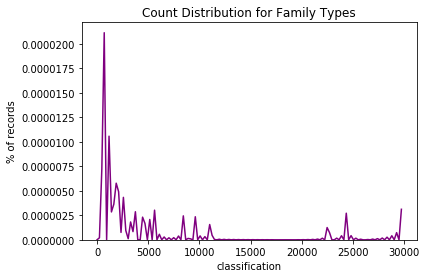

In [13]:
# Look at classification type counts
counts = model_f.classification.value_counts()
print(counts)

#plot counts
plt.figure()
sns.distplot(counts, hist = False, color = 'purple')
plt.title('Count Distribution for Family Types')
plt.ylabel('% of records')
plt.show()

There appears to be a wide distribution of counts for family types. It may be a good idea to filter for having a certain amount of recordes that are of a specific family type. 1,000 seems like a solid number that will allow a machine learning model to learn a pattern for a specific class.

In [14]:
# Get classification types where counts are over 1000
types = np.asarray(counts[(counts > 1000)].index)
print(len(types))
# Filter dataset's records for classification types > 1000
data = model_f[model_f.classification.isin(types)]
data = data.drop_duplicates(subset=["classification","sequence"])  # leaving more rows results in duplciates / index related?

print(types)
print('%d is the number of records in the final filtered dataset' %data.shape[0])

32
['HYDROLASE' 'TRANSFERASE' 'OXIDOREDUCTASE' 'IMMUNE SYSTEM'
 'HYDROLASE/HYDROLASE INHIBITOR' 'LYASE' 'TRANSCRIPTION'
 'TRANSPORT PROTEIN' 'ISOMERASE' 'VIRAL PROTEIN' 'SIGNALING PROTEIN'
 'LIGASE' 'PROTEIN BINDING' 'STRUCTURAL GENOMICS, UNKNOWN FUNCTION'
 'TRANSFERASE/TRANSFERASE INHIBITOR' 'MEMBRANE PROTEIN'
 'SUGAR BINDING PROTEIN' 'UNKNOWN FUNCTION' 'DNA BINDING PROTEIN'
 'CHAPERONE' 'STRUCTURAL PROTEIN' 'METAL BINDING PROTEIN' 'CELL ADHESION'
 'ELECTRON TRANSPORT' 'PROTEIN TRANSPORT'
 'OXIDOREDUCTASE/OXIDOREDUCTASE INHIBITOR' 'TOXIN' 'RNA BINDING PROTEIN'
 'CELL CYCLE' 'PHOTOSYNTHESIS' 'GENE REGULATION' 'DE NOVO PROTEIN']
46422 is the number of records in the final filtered dataset


In [15]:
data = data.drop_duplicates(subset=["classification","sequence"]) 
data.shape

(46422, 9)

### 3). Train Test Split
After finally filtering the dataset, a split on the data to create a training and testing set must be performed. After splitting the data, it's important to utilize the CountVectorizer to create a dictionary composed from the training dataset. This will extract individual characters or subsets of characters to gain features. An important note about using the CountVectorizer is the specification of the ngram_range. 

In a protein, it's not the individual amino acid in the protein that gives identification to what it's purpose is. There are secondary and tertiary structures that are formed via the bonds of the amino acids in the sequence. Furthermore, different parts of the chain can be more basic, and others can be more acidic, indicating it's important to use features that are larger than just one unit. As a result, using an ngram_range of (4,4) seems to be a legitmate choice for feature extraction. This will extract different subsets that are of length 4 allowing the amino acids to use their neighbors to aid in our classification.

In [16]:
## Could add n-grams
## https://stackoverflow.com/questions/18658106/quick-implementation-of-character-n-grams-using-python
# jump_size !=1 -> less overlap in n-grams. 
def char_grams(text,n=3,jump_size=2):
    return [text[i:i+n] for i in range(0,len(text)-n+1,jump_size)]

In [17]:
data.head(3).sequence.apply(char_grams)

structureId
1A4S    [AQL, LVD, DSM, MPS, SAS, STG, GSV, VVV, VTD, ...
1A6Q    [MGA, AFL, LDK, KPK, KME, EKH, HNA, AQG, GQG, ...
1A72    [STA, AGK, KVI, IKC, CKA, AAV, VLW, WEE, EKK, ...
Name: sequence, dtype: object

In [18]:
data["3mers"] = data.sequence.apply(char_grams)

In [19]:
data.tail()

,classification,residueCount,resolution,structureMolecularWeight,crystallizationTempK,densityMatthews,densityPercentSol,phValue,sequence,3mers
structureId,,,,,,,,,,
6FFL,SUGAR BINDING PROTEIN,388,1.71,44992.17,291.0,2.59,53.00,5.5,EDVRIQIWHQMIYGHRQVLAEALEKFEKENPGITVQATYRETEELR...,"[EDV, VRI, IQI, IWH, HQM, MIY, YGH, HRQ, QVL, ..."
6FG7,PROTEIN BINDING,500,1.90,56392.64,298.0,3.39,63.68,4.0,MKEIGSKPRKLLPLCFIIFLCFCSSVMAADEDDIRCLRGLKASLTD...,"[MKE, EIG, GSK, KPR, RKL, LLP, PLC, CFI, IIF, ..."
6FG8,PROTEIN BINDING,506,1.25,58478.36,298.0,1.86,33.78,5.5,MTRLTVLALLAGLLASSRAGSSMASANLEGDALHTLRVTLVDPNNV...,"[MTR, RLT, TVL, LAL, LLA, AGL, LLA, ASS, SRA, ..."
6FG8,PROTEIN BINDING,506,1.25,58478.36,298.0,1.86,33.78,5.5,MKKIFITLLWLLFISSFLCSSSSAEDDVLCLQGLKNSLIDPSSRLS...,"[MKK, KIF, FIT, TLL, LWL, LLF, FIS, SSF, FLC, ..."
6FIF,PROTEIN BINDING,837,2.54,93918.31,298.0,3.32,62.96,4.0,MKTFSSFFLSVTTLFFFSFFSLSFQASPSQSLYREIHQLISFKDVL...,"[MKT, TFS, SSF, FFL, LSV, VTT, TLF, FFF, FSF, ..."


In [20]:
data.to_csv("protein_classification_46k_ngrams.csv.gz",compression="gzip")

In [21]:
# 3). ----- Train Test Split -----

# Split Data
X_train, X_test,y_train,y_test = train_test_split(data['sequence'], data['classification'], test_size = 0.2, random_state = 1)

# Create a Count Vectorizer to gather the unique elements in sequence
vect = CountVectorizer(analyzer = 'char_wb', ngram_range = (4,4))

# Fit and Transform CountVectorizer
vect.fit(X_train)
X_train_df = vect.transform(X_train)
X_test_df = vect.transform(X_test)

#Print a few of the features
print(vect.get_feature_names()[-20:])

['zhhh', 'ziar', 'zigi', 'ziwz', 'zkal', 'zkky', 'zknt', 'zkyh', 'zlik', 'zlzk', 'zpvm', 'zrgd', 'zrvi', 'ztvl', 'ztzk', 'zvbd', 'zvib', 'zvka', 'zwdl', 'zzvb']


### 4). Machine Learning Models

With the features extracted, it's time to use machine learning models. Traditionally a Naive Bayes approach works well for these types of count vectorized features. Adaboost will be used as well for comparison.

In [22]:
# 4). ------ Machine Learning Models ------

# Make a prediction dictionary to store accuracys
prediction = dict()

# Naive Bayes Model
from sklearn.naive_bayes import MultinomialNB
model = MultinomialNB()
model.fit(X_train_df, y_train)
NB_pred = model.predict(X_test_df)
prediction["MultinomialNB"] = accuracy_score(NB_pred, y_test)
print( prediction['MultinomialNB'])

0.5542272482498654


In [23]:
# Adaboost
from sklearn.ensemble import AdaBoostClassifier
model = AdaBoostClassifier()
model.fit(X_train_df,y_train)
ADA_pred = model.predict(X_test_df)
prediction["Adaboost"] = accuracy_score(ADA_pred , y_test)
print(prediction["Adaboost"])

0.2555735056542811


###5). Visualize Metrics
It appears that Naive Bayes does better in classification than Adaboost. A visualization of a confusion matrix and a clasification report for the Navie Bayes prediction can aid in where the model performs poorly.

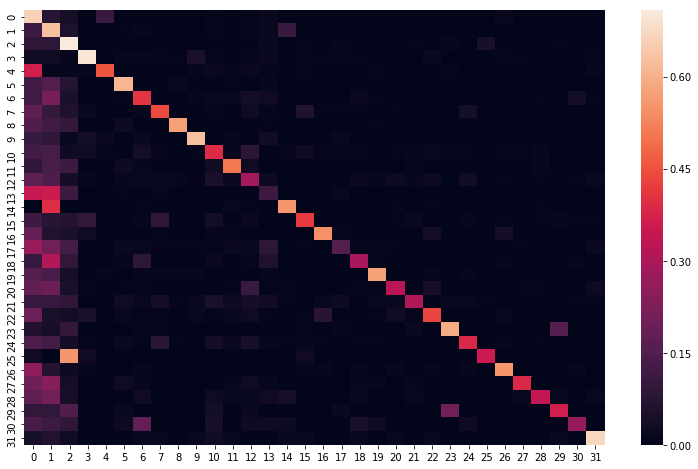

In [24]:
# 5). ----- Plot Confusion Matrix for NB -----

# Plot confusion matrix
conf_mat = confusion_matrix(y_test, NB_pred, labels = types)

#Normalize confusion_matrix
conf_mat = conf_mat.astype('float')/ conf_mat.sum(axis=1)[:, np.newaxis]

# Plot Heat Map
fig , ax = plt.subplots()
fig.set_size_inches(13, 8)
sns.heatmap(conf_mat)

The confusion matrix shows label index 3 being misclassified as index 38 quite a bit. Based on the names listed below, it makes sense for these two to be confused.

In [25]:
print(types[3])
print(types[38])

IMMUNE SYSTEM


IndexError: index 38 is out of bounds for axis 0 with size 32

Lastly, a matrix of the classification report to show case metrics for each class should be insightful

In [ ]:
#Print F1 score metrics
print(classification_report(y_test, NB_pred, target_names = types))

### Reasons for Model Error
Proteins in general can be a type of enzyme, or a signaling protein, structural, and various other choices. A lof of proteins tend to share very similar characteristics, as some proteins are meant to bind in similar regions as others. For example, a Hydrolase enzyme and a Hydrolase inhibitor protein are going to have similar structures as they will target very similar areas. This is reflected in the confusion matrix and heat map. Gene regulator proteins will have a similarity to RNA binding proteins, DNA binding proteins, as well as transcription proteins.  The biggest thing to note as well, as the model only uses features of 4 amino acids at most. The possibility of utilizing amino acids of higher degree in theory should be able to create an even higher accuracy.

### Future Work
There is definitely room for improvement for the model. Utilizing factors such as pH, molecular weight, and other components may be able to yield more information on family group. Furthermore, if possible, increase the length of the ngram_range to include more than just 4 characters to allow for higher interaction between the amino acids as reflected in reality

